## Global Open Science Electrophysiology

### 9. Causality and mediation tools for q-EEG and clinical applications

Tutorials created by Qing Wang (Vincent), all related materials regarding this tutorial are in this [GitHub Repo](https://github.com/Vincent-wq/causal_course_eeg).

In [1]:
# import libs used in this example
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import graphviz

import dowhy
from dowhy import CausalModel

from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

print("dowhy version = ", dowhy.__version__)

/opt/conda/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


dowhy version =  0.11.1


/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Example set up using qEEG as mediator for treatment effect of neuroEPO

Notice: This is a **simulation example** for tutorial purpose only using the clinical settings from the Maria's paper entitled [The Effect of Neuroepo on Cognition in Parkinson’s Disease Patients Is Mediated by Electroencephalogram Source Activity](https://www.frontiersin.org/journals/neuroscience/articles/10.3389/fnins.2022.841428/full).

#### The mediation model in the original paper is as follows:

![image](https://www.frontiersin.org/files/Articles/841428/fnins-16-841428-HTML-r1/image_m/fnins-16-841428-g001.jpg)

In [2]:
# Definition of graph
import matplotlib.pyplot as plt
import networkx as nx

# Read the GML graph
from networkx.drawing.nx_pydot import graphviz_layout

## initialize a graph
def graph_init(DIRECTED, node_list, node_label_list, edge_list, edge_weight_lsit ):
    # Construct the graph (the graph is constant for all iterations)
    # Direction
    if DIRECTED:
        gml_string = 'graph [directed 1\n'
    else:
        gml_string = 'graph [directed 0\n'

    # Generate the GML graph
    for i_node in range(len(node_list)):
        gml_string += f'\tnode [id "{node_list[i_node]}" label "{node_label_list[i_node]}"]\n'
    # Generate edges
    for i_edge in range(len(edge_list)):
        gml_string += f'\tedge [source "{edge_list[i_edge][0]}" target "{edge_list[i_edge][1]}" weight "{edge_weight_lsit[i_edge]}"]\n'
    
    gml_string += ']'

    return gml_string

## visualize a graph
def show_graph(gml_str, title_str):
    from io import StringIO
    ## Parsing graph
    gml_file_like = StringIO(gml_str)
    G = nx.parse_gml(gml_file_like)
    # Create layout
    #pos = nx.circular_layout(G)
    pos = graphviz_layout(G)

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_shape='o', node_size=1500)
    # Draw the edges
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(data=True), arrowstyle='-|>', 
                           arrowsize=50, connectionstyle ="arc3,rad=0.05")
    # Draw the node labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

    # Draw the edge labels (weights)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=14)
    plt.title(title_str)
    plt.axis('off') 
    plt.show()
    #return 1

In [3]:
# First, we'll build the ground truth causal structure, i.e. structrual causal model (SCM)

class neuroEPO_SCM:
    def __init__(self, random_seed=None):
        self.random_seed = random_seed
        self.u_x = stats.truncnorm(0, np.infty, scale=4)
        self.u_y = stats.norm(scale=2)
        self.u_z = stats.norm(scale=2)
        self.u = stats.truncnorm(0, np.infty, scale=4)
        
    def sample(self, sample_size=100, treatment_value=None):
        """Samples from the SCM"""
        if self.random_seed:
            np.random.seed(self.random_seed)
        
        u_x = self.u_x.rvs(sample_size)
        u_y = self.u_y.rvs(sample_size)
        u_z = self.u_z.rvs(sample_size)
        u = self.u.rvs(sample_size)
        
        if treatment_value:
            x_ = np.array([treatment_value]*sample_size)
        else:
            x_ = u_x + 0.7*u

        # Creating the Golden standard model
        # The direct effect x->y = 0.9
        # The indirect effetct x->m = -0.6  * m->y = 1.0 = -0.6   
        # The total effect will be x->y + x->m->y = 0.9 + -0.6*1.0 = 0.3
        m_ = -0.6*x_ + 0.25*u_z
        y_ =  1.0*m_ + 0.9*x_ + 0.25*u
        
        # 
        nodes_list = ['X', 'M', 'Y', 'U']
        nodes_label__list = ['neuroEPO', 'qEEG', 'Cognition', 'Education']

        link_list   = ['XM', 'MY', 'XY', 'UY', "UX"]
        link_weight = [-0.6,  1.0,  0.9, 0.25, 0.7]

        model_str = graph_init(1, nodes_list, nodes_label__list, link_list, link_weight)
        
        return x_, m_, y_, u, model_str
    
    def intervene(self, treatment_value, sample_size=100):
        """Intervenes on the SCM"""
        return self.sample(treatment_value=treatment_value, sample_size=sample_size)

In [4]:
# Instantiate the SCM
scm = neuroEPO_SCM(random_seed = 0)

# Generate observations:
neuro_EPO_obv, qEEG_obv, cognition_obv, factor1_obv, model_gt = scm.sample(1000)

# Encode as a pandas df
df = pd.DataFrame(np.vstack([neuro_EPO_obv, qEEG_obv, cognition_obv, factor1_obv]).T, columns=['neuroEPO', 'qEEG', 'Cognition', 'Education'])
print("Our simulation dataset looks like this (first 5 observations):")
display(df.head(5))

# We can define the model by specifying the data, treatment, outcome and common causes if there are some.
model = CausalModel(
    data=df,
    treatment='neuroEPO',
    outcome='Cognition',
    common_causes = 'Education',
    graph=model_gt
)

Our simulation dataset looks like this (first 5 observations):


,neuroEPO,qEEG,Cognition,Education
0,4.204261,-1.829914,2.069101,0.460718
1,3.594291,-2.628963,1.335838,2.919754
2,3.734913,-2.114013,1.746540,1.996527
3,5.293450,-4.218653,2.415617,7.480655
4,9.843106,-5.492535,4.063866,2.790420


You can use the build in method model.view_model() for a quick view of the graphical model specified:

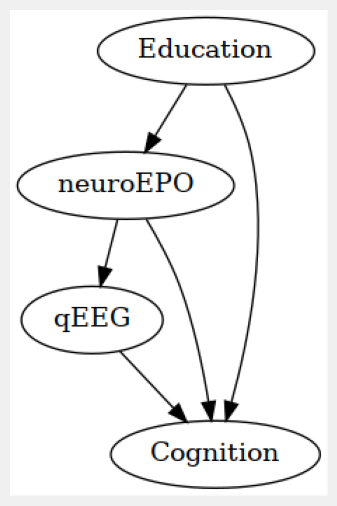

In [5]:
model.view_model()

Or, customize your graph visualization with networkX: 

/tmp/ipykernel_816200/1780900219.py:36: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G)


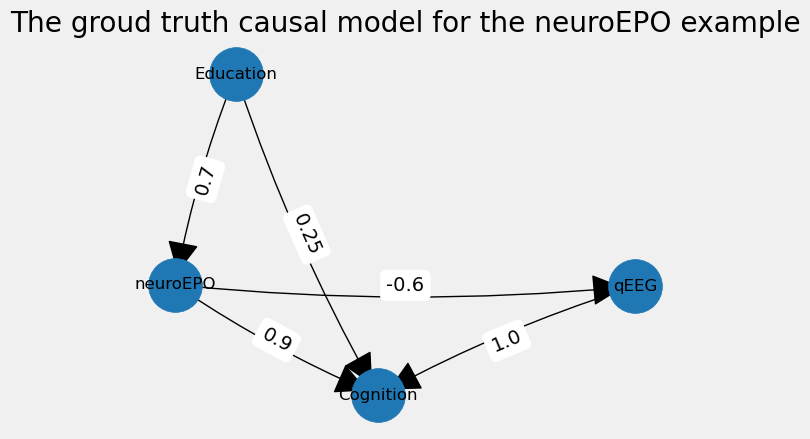

In [6]:
show_graph(model_gt, "The groud truth causal model for the neuroEPO example")

Now, we define the estimand, by default it is average treatment effcet, doWhy will remind you of the unfoundedness assumption.

In [7]:
estimand = model.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                             
───────────(E[Cognition|Education])
d[neuroEPO]                        
Estimand assumption 1, Unconfoundedness: If U→{neuroEPO} and U→Cognition then P(Cognition|neuroEPO,Education,U) = P(Cognition|neuroEPO,Education)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Now, we are need to choose the methods to estimate the causal effect:

In [8]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.linear_regression')
print(f'Estimate of causal effect (linear regression): {estimate.value}')

Estimate of causal effect (linear regression): 0.2952406686892681


/opt/conda/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Never forget about the **sensitivity analysis/refutation test** in causal inference, we need to know what the effect of interest will be if, for example, we have less data?

#### Test1: **What** will the effect be **if** we have less data, like only 40%?

In [9]:
refute_subset = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name="data_subset_refuter", 
    subset_fraction=0.4)

/opt/conda/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/opt/conda/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/opt/conda/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame 

In [10]:
print(refute_subset)

Refute: Use a subset of data
Estimated effect:0.2952406686892681
New effect:0.29435741213392946
p value:0.86



#### Test2: **What** will the effect be **if** we add a random common cause?

In [11]:
random_cause = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name='random_common_cause'
)

/opt/conda/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/opt/conda/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/opt/conda/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame 

In [12]:
print(random_cause)

Refute: Add a random common cause
Estimated effect:0.2952406686892681
New effect:0.295244724196445
p value:0.9199999999999999



#### Test3: **What** will the effect be **if** we replace our treatment with a placebo?

In [13]:
placebo_refuter = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name='placebo_treatment_refuter'
)

/opt/conda/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


/opt/conda/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/opt/conda/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/conda/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/opt/conda/lib/python3.9/site-packages/statsmodels/regression/linear_model.py

In [14]:
print(placebo_refuter)

Refute: Use a Placebo Treatment
Estimated effect:0.2952406686892681
New effect:0.0
p value:1.0



### Now let us look at the mediation effect, let us start with [statsmodels](https://www.statsmodels.org/stable/), which is very similar to R

##### Let us recall our causal structrual model

/tmp/ipykernel_816200/1780900219.py:36: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G)


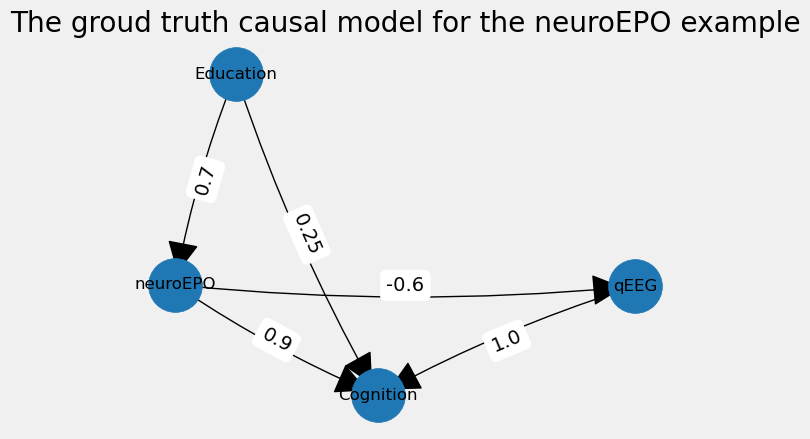

In [15]:
show_graph(model_gt, "The groud truth causal model for the neuroEPO example")

In [16]:
import statsmodels
print("statsmodels version: ", statsmodels.__version__)
import statsmodels.api as sm
from statsmodels.stats.mediation import Mediation

# Specify the outcome model
outcome_model  = sm.OLS.from_formula("Cognition ~ neuroEPO + qEEG + Education", df) 
# Specify the mediation model
mediator_model = sm.OLS.from_formula(" qEEG ~ neuroEPO ", df) 

med = Mediation(outcome_model, mediator_model, "neuroEPO", "qEEG").fit()
med.summary()

statsmodels version:  0.14.1


,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),-0.604728,-0.649543,-0.560951,0.0
ACME (treated),-0.604728,-0.649543,-0.560951,0.0
ADE (control),0.900000,0.900000,0.900000,0.0
ADE (treated),0.900000,0.900000,0.900000,0.0
Total effect,0.295272,0.250457,0.339049,0.0
Prop. mediated (control),-2.043113,-2.593433,-1.654488,0.0
Prop. mediated (treated),-2.043113,-2.593433,-1.654488,0.0
ACME (average),-0.604728,-0.649543,-0.560951,0.0
ADE (average),0.900000,0.900000,0.900000,0.0
Prop. mediated (average),-2.043113,-2.593433,-1.654488,0.0
